## 1.0 Import libraries

In [2]:
import tensorflow as tf
import os

In [3]:
#Avoid OOM errors by setting GPU Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

## 2. Remove dodgy images

In [6]:
import cv2
import imghdr

In [7]:
data_dir = 'data'

In [8]:
image_exts = ['jpeg','jpg','bmp','png']

In [9]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in extensions list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

## 3. Load Data

In [10]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 771 files belonging to 3 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

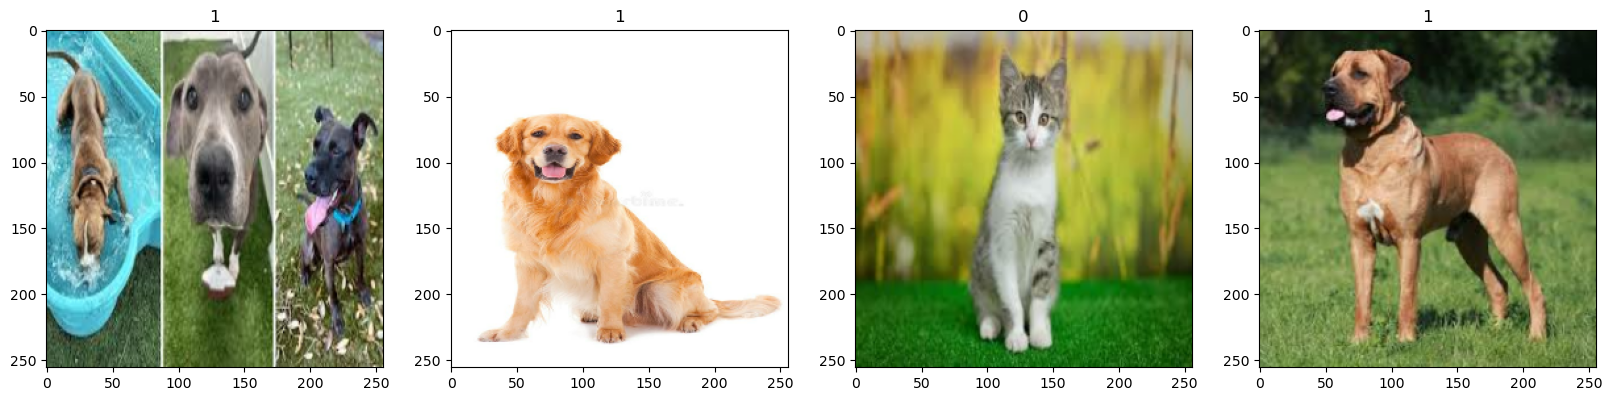

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

## 4. Scale Data

In [17]:
data = data.map(lambda x,y: (x/255, y))

In [19]:
data.as_numpy_iterator().next()

(array([[[[0.4656786 , 0.6931296 , 0.30097273],
          [0.4519378 , 0.6774127 , 0.28426778],
          [0.43655026, 0.6561581 , 0.26007965],
          ...,
          [0.4499617 , 0.665648  , 0.25780484],
          [0.45490196, 0.67058825, 0.2627451 ],
          [0.45490196, 0.67058825, 0.2627451 ]],
 
         [[0.46963716, 0.6970881 , 0.30493128],
          [0.45763633, 0.6831112 , 0.2899663 ],
          [0.44224876, 0.6618566 , 0.26577818],
          ...,
          [0.45645788, 0.6721442 , 0.26650473],
          [0.4606005 , 0.67628676, 0.2694008 ],
          [0.4606005 , 0.67628676, 0.2719236 ]],
 
         [[0.47329962, 0.7018536 , 0.3096967 ],
          [0.46328998, 0.6898678 , 0.29658395],
          [0.44854653, 0.66879416, 0.27239582],
          ...,
          [0.46517083, 0.68164015, 0.27889812],
          [0.4677696 , 0.6844199 , 0.27910432],
          [0.4677696 , 0.68405366, 0.28394642]],
 
         ...,
 
         [[0.5282217 , 0.6570962 , 0.38933465],
          [0.48748

## 5. Split Data

In [20]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [21]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

## 6. Build Deep Learning Model

In [22]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [24]:
model = Sequential()

In [25]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [26]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

## 7. Train

In [28]:
logdir = 'logs'

In [29]:
tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [30]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorflow_callback])

Epoch 1/20


2024-10-16 05:09:59.630271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [771]
	 [[{{node Placeholder/_4}}]]
2024-10-16 05:09:59.630983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [771]
	 [[{{node Placeholder/_4}}]]


17/17 [==============================] - ETA: 0s - loss: 0.8911 - accuracy: 0.4945

2024-10-16 05:10:28.681242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [771]
	 [[{{node Placeholder/_4}}]]
2024-10-16 05:10:28.682500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [771]
	 [[{{node Placeholder/_4}}]]


17/17 [==============================] - 34s 2s/step - loss: 0.8911 - accuracy: 0.4945 - val_loss: 0.6984 - val_accuracy: 0.4875
Epoch 2/20
17/17 [==============================] - 30s 2s/step - loss: 0.6562 - accuracy: 0.6085 - val_loss: 0.6555 - val_accuracy: 0.6187
Epoch 3/20
17/17 [==============================] - 27s 1s/step - loss: 0.6398 - accuracy: 0.6250 - val_loss: 0.6922 - val_accuracy: 0.5375
Epoch 4/20
17/17 [==============================] - 28s 2s/step - loss: 0.6225 - accuracy: 0.6544 - val_loss: 0.6108 - val_accuracy: 0.6313
Epoch 5/20
17/17 [==============================] - 34s 2s/step - loss: 0.5947 - accuracy: 0.7077 - val_loss: 0.5769 - val_accuracy: 0.6750
Epoch 6/20
17/17 [==============================] - 27s 2s/step - loss: 0.5280 - accuracy: 0.7500 - val_loss: 0.5720 - val_accuracy: 0.7250
Epoch 7/20
17/17 [==============================] - 28s 2s/step - loss: 0.4831 - accuracy: 0.7665 - val_loss: 0.4987 - val_accuracy: 0.7812
Epoch 8/20
17/17 [=============

## 8. Plot Performance

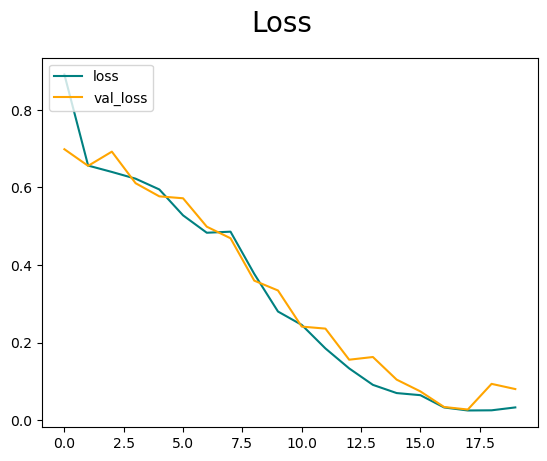

In [31]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

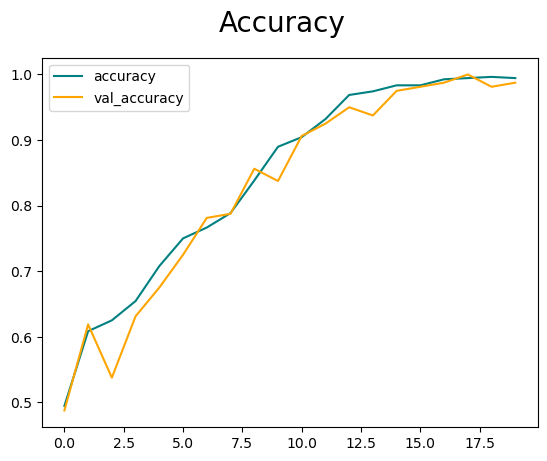

In [32]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

## 9. Evaluate

In [33]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [34]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [36]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 192ms/step


In [37]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.98550725, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32) tf.Tensor(0.9921875, shape=(), dtype=float32)


## 10. Test

In [38]:
import cv2

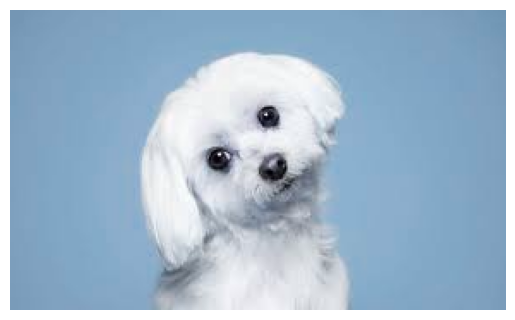

In [39]:
img = cv2.imread(os.path.join('data','dogs', 'images116.jpg'))
plt.imshow(img)
plt.axis(False)
plt.show()

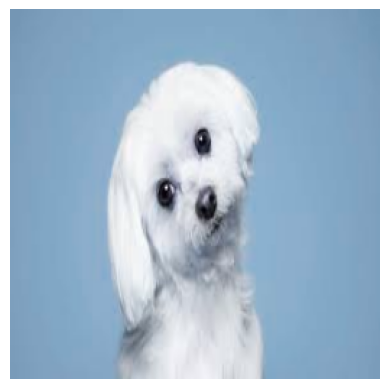

In [40]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.axis(False)
plt.show()

In [41]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 131ms/step


In [42]:
yhat

array([[0.97884285]], dtype=float32)

In [43]:
if yhat > 0.5: 
    print(f'Predicted class is a Dog')
else:
    print(f'Predicted class is a Cat')

Predicted class is a Dog


## 11. Save Model

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save(os.path.join('models','dog_cat_classifier.h5'))

In [46]:
new_model = load_model(os.path.join('models', 'dog_cat_classifier.h5'))

In [47]:
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 103ms/step


array([[0.97884285]], dtype=float32)